In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

Будем учиться классифицировать жанры музыки. В отличие от проекта, который вас ждет, здесь мы будем работать не с сырыми данными (аудиодорожками), а уже в осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [3]:
data = pd.read_csv("../data_folder/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
data.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


In [6]:
data.isnull().sum() 

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

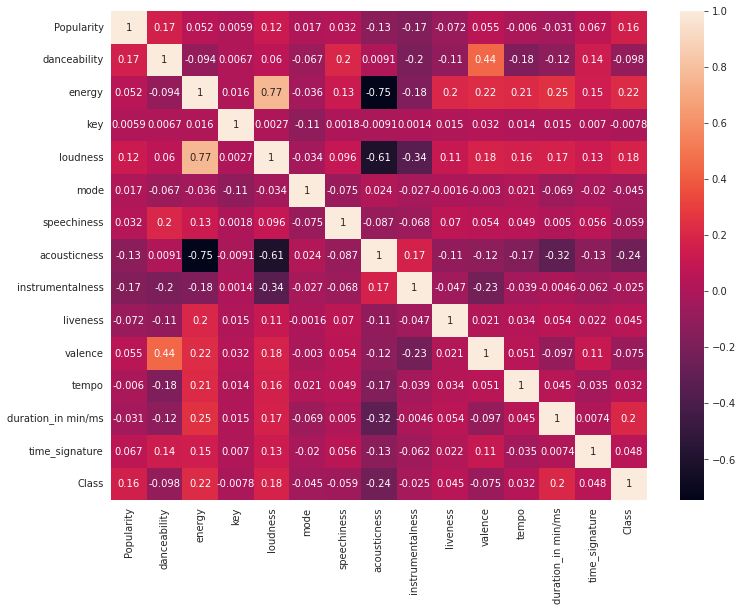

In [7]:
sns.heatmap(data.corr(), annot=True); 

<AxesSubplot:>

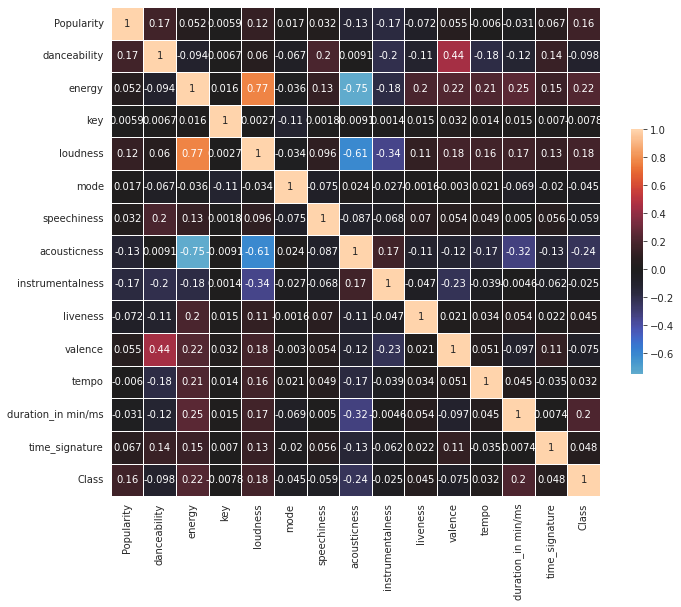

In [8]:
# Другая корреляционная матрица

corr = data.corr()

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

In [9]:
(data[["instrumentalness", "key", "Popularity"]] == 0).sum(axis=0) #т.е. нулей нет, т.е. можно превратить Nan в 0

instrumentalness    0
key                 0
Popularity          0
dtype: int64

In [10]:
data[["instrumentalness", "key", "Popularity"]] = data[["instrumentalness", "key", "Popularity"]].replace(np.nan, 0)

In [11]:
data.isnull().sum() 

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

#### доп еда

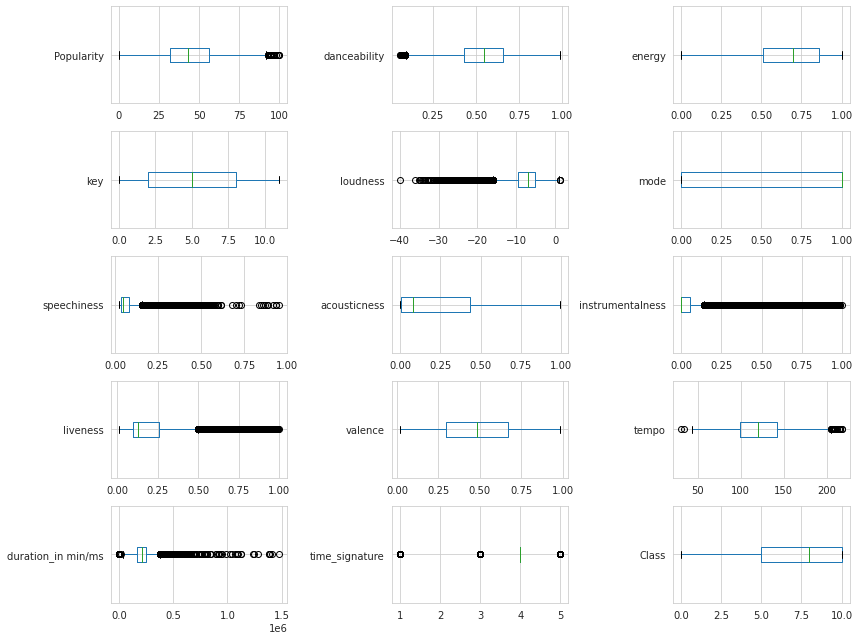

In [12]:
fig, axes = plt.subplots(5, 3)

for i, el in enumerate(list(data.drop(['Artist Name', 'Track Name'], axis=1).columns.values)):
    data.boxplot(el, ax=axes.flatten()[i], vert=False)

plt.tight_layout()
plt.show()

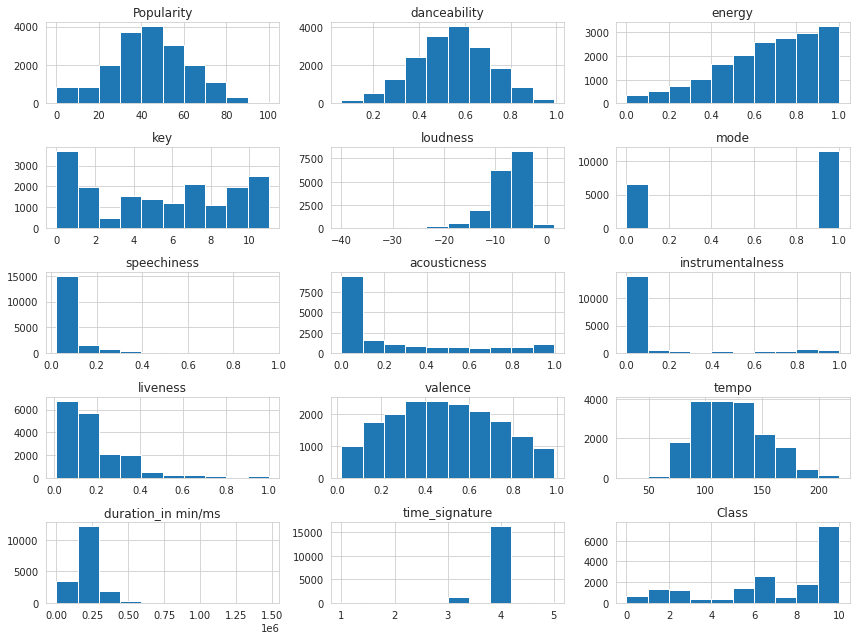

In [13]:
fig, axes = plt.subplots(5, 3)

for i, el in enumerate(list(data.drop(['Artist Name', 'Track Name'], axis=1).columns.values)):
    data.hist(el, ax=axes.flatten()[i])

plt.tight_layout() 
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder

data_dum = data[['Artist Name', 'Class']]
data_dum = data_dum.sort_values(by=['Class', 'Artist Name'])

le = LabelEncoder()
data_dum = data_dum[data_dum.columns[:]].apply(le.fit_transform)

<AxesSubplot:>

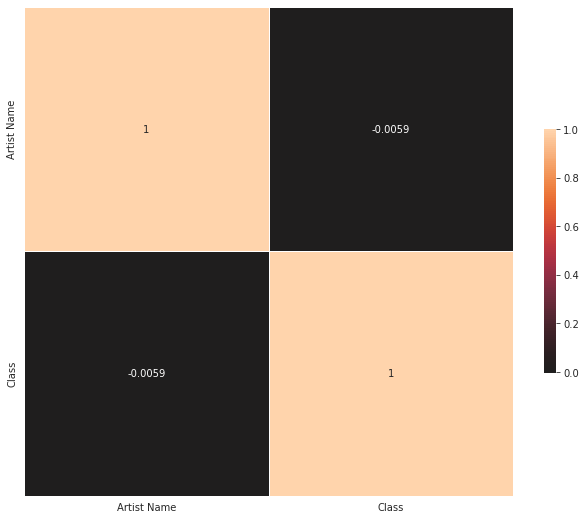

In [15]:
corr = data_dum.corr()

f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)


> Артист не исполняет в каком-то одном классе? Можно попробовать убрать и имя артиста.

In [16]:
new_data = data.drop(['Track Name', 'Artist Name'], axis=1)

In [17]:
new_data.Class.value_counts()

10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: Class, dtype: int64

> классы не сбалансированны.

In [18]:
# так как классы не сбалансированны, сбалансируем.
from sklearn.utils import resample

df_01 = new_data[new_data.Class==1]
df_02 = new_data[new_data.Class==2]
df_03 = new_data[new_data.Class==3]
df_04 = new_data[new_data.Class==4]
df_05 = new_data[new_data.Class==5]
df_06 = new_data[new_data.Class==6]
df_07 = new_data[new_data.Class==7]
df_08 = new_data[new_data.Class==8]
df_09 = new_data[new_data.Class==9]
df_10 = new_data[new_data.Class==10]

upsampled_01 = resample(df_01, replace=True, n_samples=4949, random_state=123)
upsampled_02 = resample(df_02, replace=True, n_samples=4949, random_state=123)
upsampled_03 = resample(df_03, replace=True, n_samples=4949, random_state=123)
upsampled_04 = resample(df_04, replace=True, n_samples=4949, random_state=123)
upsampled_05 = resample(df_05, replace=True, n_samples=4949, random_state=123)
upsampled_06 = resample(df_06, replace=True, n_samples=4949, random_state=123)
upsampled_07 = resample(df_07, replace=True, n_samples=4949, random_state=123)
upsampled_08 = resample(df_08, replace=True, n_samples=4949, random_state=123)
upsampled_09 = resample(df_09, replace=True, n_samples=4949, random_state=123)

bal_data = pd.concat([df_10, upsampled_01, upsampled_02, upsampled_03,
                          upsampled_04, upsampled_05, upsampled_06,
                          upsampled_07, upsampled_08, upsampled_09])
 
bal_data.Class.value_counts()

10    4949
1     4949
2     4949
3     4949
4     4949
5     4949
6     4949
7     4949
8     4949
9     4949
Name: Class, dtype: int64

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

#### Подготовка данных

In [19]:
# данные с превращением имени исполнителя в dummies переменные, без стандартизации:

X = data.drop(['Track Name', 'Class'], axis=1)
X = pd.get_dummies(X)

y = data["Class"]

# делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# стандартизированные данные без использование имени исполнителя:

X_q = new_data.drop(['Class'], axis=1)
y_q = new_data["Class"]

# делим на трейн и тест
X_q_train, X_q_test, y_q_train, y_q_test = train_test_split(X_q, y_q, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_q_train = scaler.fit_transform(X_q_train)
X_q_test = scaler.transform(X_q_test)

#### Подготовка сбалансированных и стандартизованных данных

In [21]:
Xb = bal_data.drop(['Class'], axis=1)
yb = bal_data["Class"]

In [22]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42)

In [23]:
scaler = StandardScaler()
Xb_train = scaler.fit_transform(Xb_train)
Xb_test = scaler.transform(Xb_test)

#### Обучение дерева на данных c dummies переменными, без стандартизации:

In [24]:
# если без подкручивания параметров :
cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)
y_pred_basic = cls.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_basic), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_basic, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_basic, average="macro"), 4)}')

accuracy_score:	0.3964
precision_score:0.4843
recall_score: 	0.4845
f1_score: 	0.4836


In [26]:
# словарик параметров для тюнинга модели
parameters = {'criterion': ['gini', 'entropy'], 
              'max_depth': range(2, 20, 4), 
              'min_samples_split': range(2, 6, 2),
              'min_samples_leaf' : range(2, 6, 2)}

# пробуем разную глубину дерева,
# разное количество значений в листе, который можно посплитить 
# и разное минимальное количество значений в последнем листе

# собственно сам тюнинг
cls_m = DecisionTreeClassifier()
grid_search_cv_cls = GridSearchCV(cls_m, parameters, cv=5, n_jobs=2)

grid_search_cv_cls.fit(X_train, y_train)

cls_dgs_best = grid_search_cv_cls.best_estimator_

print(grid_search_cv_cls.best_params_)
print(grid_search_cv_cls.best_estimator_)

print('\n')

y_dgs_pred = cls_dgs_best.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_dgs_pred), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_dgs_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_dgs_pred, average="macro"), 4)}')

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 4}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=4)


accuracy_score:	0.4828
precision_score:0.5469
recall_score: 	0.52
f1_score: 	0.5174


#### Обучение дерева на данных без имени исполнители (без номинативных) и с стандартизацией:

In [27]:
# без подбора
cls_q = DecisionTreeClassifier()
cls_q.fit(X_q_train, y_q_train)

y_pred_basic_q = cls_q.predict(X_q_test)

print(f'accuracy_score:\t{round(accuracy_score(y_q_test, y_pred_basic_q), 4)}')
print(f'precision_score:{round(precision_score(y_q_test, y_pred_basic_q, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_q_test, y_pred_basic_q, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_q_test, y_pred_basic_q, average="macro"), 4)}')

accuracy_score:	0.3772
precision_score:0.4585
recall_score: 	0.4645
f1_score: 	0.4605


In [28]:
# собственно сам тюнинг, используем те же параметры (parameters)

cls_q = DecisionTreeClassifier()
grid_search_cv_cls_q = GridSearchCV(cls_q, parameters, cv=5, n_jobs=2)

grid_search_cv_cls_q.fit(X_q_train, y_q_train)
grid_search_cv_cls_q.best_params_

cls_best_q = grid_search_cv_cls_q.best_estimator_

print(grid_search_cv_cls_q.best_params_)
print(grid_search_cv_cls_q.best_estimator_)

print('\n')

y_pred_q = cls_best_q.predict(X_q_test)

print(f'accuracy_score:\t{round(accuracy_score(y_q_test, y_pred_q), 4)}')
print(f'precision_score:{round(precision_score(y_q_test, y_pred_q, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_q_test, y_pred_q, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_q_test, y_pred_q, average="macro"), 4)}')

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
DecisionTreeClassifier(max_depth=10, min_samples_leaf=4)


accuracy_score:	0.4728
precision_score:0.5289
recall_score: 	0.5079
f1_score: 	0.5031


> метрики почти не изменились

#### Обучение дерева на сбалансированных и стандартизированных данных

с подбором параметров

In [29]:
# без подбора
cls_b = DecisionTreeClassifier()
cls_b.fit(Xb_train, yb_train)

y_pred_b = cls_b.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, y_pred_b), 4)}')
print(f'precision_score:{round(precision_score(yb_test, y_pred_b, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, y_pred_b, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, y_pred_b, average="macro"), 4)}')

accuracy_score:	0.8523
precision_score:0.8484
recall_score: 	0.8553
f1_score: 	0.8437


> даже без подбора параметров намного лучше

In [46]:
cls_b.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [30]:
# параметры те же
d_t = DecisionTreeClassifier()

grid = GridSearchCV(d_t, parameters, cv=5, scoring='f1_macro', n_jobs=2)
grid.fit(Xb_train, yb_train)

# классификатор
clf = grid.best_estimator_

print(grid.best_params_)
print(grid.best_estimator_)

yb_d_pred = clf.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, yb_d_pred), 4)}')
print(f'precision_score:{round(precision_score(yb_test, yb_d_pred, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, yb_d_pred, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, yb_d_pred, average="macro"), 4)}')

{'criterion': 'entropy', 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2}
DecisionTreeClassifier(criterion='entropy', max_depth=18, min_samples_leaf=2)
accuracy_score:	0.8265
precision_score:0.8191
recall_score: 	0.8299
f1_score: 	0.8169


> дерево со стандартными параметрами лучше получилось (?).

### Задание 3. Другие модели (5 баллов за модель)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

#### 3.1 kNN

In [31]:
# с kNN с номинативными признаками (без подбора параметров):
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

y_pred_knn = knn_clf.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_knn), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_knn, average="macro"), 4)}')

accuracy_score:	0.235
precision_score:0.2758
recall_score: 	0.2846
f1_score: 	0.2781


> хуже чем DecisionTreeClassifier

In [32]:
# с kNN без номинативных признаков (без подбора параметров, стандартизированные):
knn_clf_q = KNeighborsClassifier()
knn_clf_q.fit(X_q_train, y_q_train)

y_pred_knn_q = knn_clf_q.predict(X_q_test)

print(f'accuracy_score:\t{round(accuracy_score(y_q_test, y_pred_knn_q), 4)}')
print(f'precision_score:{round(precision_score(y_q_test, y_pred_knn_q, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_q_test, y_pred_knn_q, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_q_test, y_pred_knn_q, average="macro"), 4)}')

accuracy_score:	0.4303
precision_score:0.4875
recall_score: 	0.4988
f1_score: 	0.4919


In [33]:
# подберем параметры, используем сбалансированные стандартизированные данные, без номинативных признаков
# ищет ОЧЕНЬ медленно!!!!

k_range = list(range(2, 20, 3))
weight_options = ["uniform", "distance"]
metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']

param_grid = dict(n_neighbors = k_range, weights = weight_options, metric=metric)

neigh = KNeighborsClassifier()

clf = GridSearchCV(neigh, param_grid, cv = 10, scoring = 'f1_macro')
clf.fit(Xb_train, yb_train)

best_knn = clf.best_estimator_

print (clf.best_score_)
print (clf.best_params_)
print (clf.best_estimator_)

0.8369214444619582
{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}
KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')


In [34]:
# классификатор
yb_pred_knn = best_knn.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, yb_pred_knn), 4)}')
print(f'precision_score:{round(precision_score(yb_test, yb_pred_knn, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, yb_pred_knn, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, yb_pred_knn, average="macro"), 4)}')

accuracy_score:	0.859
precision_score:0.859
recall_score: 	0.8618
f1_score: 	0.8521


> Хорош. всего лишь немного хуже, чем DecisionTreeClassifier без подбора параметров

#### Логистическая регрессия

In [35]:
# с логистической регрессией и номинативными признаками (без подбора параметров):
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_knn), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_knn, average="macro"), 4)}')

accuracy_score:	0.235
precision_score:0.2758
recall_score: 	0.2846
f1_score: 	0.2781


In [36]:
# с логистической регрессией и без номинативных признаков (без подбора параметров):
log_clf_q = LogisticRegression()
log_clf_q.fit(X_q_train, y_q_train)

y_pred_log_q = log_clf_q.predict(X_q_test)

print(f'accuracy_score:\t{round(accuracy_score(y_q_test, y_pred_knn_q), 4)}')
print(f'precision_score:{round(precision_score(y_q_test, y_pred_knn_q, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_q_test, y_pred_knn_q, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_q_test, y_pred_knn_q, average="macro"), 4)}')

accuracy_score:	0.4303
precision_score:0.4875
recall_score: 	0.4988
f1_score: 	0.4919


/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# без номинативных признаков (без подбора параметров, стандартизированные):
log_clf_b = LogisticRegression()
log_clf_b.fit(Xb_train, yb_train)

y_pred_clf_b = log_clf_b.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, y_pred_clf_b), 4)}')
print(f'precision_score:{round(precision_score(yb_test, y_pred_clf_b, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, y_pred_clf_b, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, y_pred_clf_b, average="macro"), 4)}')

accuracy_score:	0.5695
precision_score:0.5529
recall_score: 	0.5746
f1_score: 	0.5505


/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> хуже.

#### Random forest

In [38]:
# с рэндом форрест и номинативными признаками (без подбора параметров):
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print(f'accuracy_score:\t{round(accuracy_score(y_test, y_pred_knn), 4)}')
print(f'precision_score:{round(precision_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_test, y_pred_knn, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_test, y_pred_knn, average="macro"), 4)}')

accuracy_score:	0.235
precision_score:0.2758
recall_score: 	0.2846
f1_score: 	0.2781


In [39]:
# с рэндом форрест и без номинативных признаков (без подбора параметров):
rf_clf_q = RandomForestClassifier()
rf_clf_q.fit(X_q_train, y_q_train)

y_pred_rf_q = rf_clf_q.predict(X_q_test)

print(f'accuracy_score:\t{round(accuracy_score(y_q_test, y_pred_rf_q), 4)}')
print(f'precision_score:{round(precision_score(y_q_test, y_pred_rf_q, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(y_q_test, y_pred_rf_q, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(y_q_test, y_pred_rf_q, average="macro"), 4)}')

accuracy_score:	0.5044
precision_score:0.5862
recall_score: 	0.5742
f1_score: 	0.575


In [40]:
# с рэндом форрест с сбалансированными данными:

rf_clf_b = RandomForestClassifier()
rf_clf_b.fit(Xb_train, yb_train)

y_pred_rf_b = rf_clf_b.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, y_pred_rf_b), 4)}')
print(f'precision_score:{round(precision_score(yb_test, y_pred_rf_b, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, y_pred_rf_b, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, y_pred_rf_b, average="macro"), 4)}')

accuracy_score:	0.872
precision_score:0.8684
recall_score: 	0.8747
f1_score: 	0.8688


> RandomForestClassifier без подбора лучше, чем DecisionTreeClassifier с подбором параметров на сбалансированных и стандарттизированных данных

In [47]:
rf_clf_b.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [49]:
parameters = {'n_estimators': range(30, 150, 20),
              'max_features': range(1, 200, 20), 
              'min_samples_split': range(1, 6, 1),
              'min_samples_leaf' : range(1, 6, 1)}

cls_brf = RandomForestClassifier()
grid_brf = GridSearchCV(cls_brf, parameters, cv=5, n_jobs=2, scoring = 'f1_macro')

grid_brf.fit(Xb_train, yb_train)
grid_brf.best_params_

cls_best_brf = grid_brf.best_estimator_

print(grid_brf.best_params_)
print(grid_brf.best_estimator_)

print('\n')

y_pred_brf = grid_brf.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, y_pred_brf), 4)}')
print(f'precision_score:{round(precision_score(yb_test, y_pred_brf, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, y_pred_brf, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, y_pred_brf, average="macro"), 4)}')

/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6900 fits failed out of a total of 7500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/yuliya/.cache/pypoetry/virtualenvs/bi-ml-2021-NEzni0Ey-py3.10/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/home/yuliya/.

{'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 130}
RandomForestClassifier(max_features=1, n_estimators=130)


accuracy_score:	0.8761
precision_score:0.8733
recall_score: 	0.8789
f1_score: 	0.8735


#### AdaBoostClassifier

In [42]:
# с сбалансированными данными:

clf_ab = AdaBoostClassifier(n_estimators=15, random_state=42)
clf_ab.fit(Xb_train, yb_train)

y_pred_ab = clf_ab.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, y_pred_ab), 4)}')
print(f'precision_score:{round(precision_score(yb_test, y_pred_ab, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, y_pred_ab, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, y_pred_ab, average="macro"), 4)}')

accuracy_score:	0.4873
precision_score:0.479
recall_score: 	0.4918
f1_score: 	0.4788


#### GaussianNB

In [43]:
# с сбалансированными данными:

clf_gnb = GaussianNB()
clf_gnb.fit(Xb_train, yb_train)

y_pred_gn = clf_gnb.predict(Xb_test)

print(f'accuracy_score:\t{round(accuracy_score(yb_test, y_pred_gn), 4)}')
print(f'precision_score:{round(precision_score(yb_test, y_pred_gn, average="macro"), 4)}')
print(f'recall_score: \t{round(recall_score(yb_test, y_pred_gn, average="macro"), 4)}')
print(f'f1_score: \t{round(f1_score(yb_test, y_pred_gn, average="macro"), 4)}')

accuracy_score:	0.5372
precision_score:0.5357
recall_score: 	0.541
f1_score: 	0.5154


### Задание 4. (3 балла)

Раз уж вы работаете в командах, то у вас есть шанс обсудить любимые фильмы. Напишите сюда 3 фильма, которые хотели бы посмотреть вместе:

1.

2.

3.